# Machine learning for chemistry 1

This exercise is for practising to representation of molecules and kernel-ridge regression (KRR) method in ML for chemistry. We will train the atomization energies of molecules and predict unknown ones.

Required packages include numpy, scikit-learn, qml, etc. 

#### Required packages:
Scikit-learn https://scikit-learn.org/stable/  
QML https://github.com/qmlcode/qml 

Please make sure you have QML installed on your python environment. If not, please follow http://www.qmlcode.org/installation.html

This exerices is created based on a turorial https://github.com/qmlcode/tutorial given by Anders Steen Christensen, etc.

## Load numpy and QML into Jupyter Notebook

In [ ]:
!pip install seaborn
!pin install pandas
!pip install scikit-learn
!pip install qml

In [1]:
import os
import random
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn import metrics

try:
    import qml
    from qml.representations import get_slatm_mbtypes
    print("QML version:",qml.__version__)
except ImportError:
    print("Failed to find QML")
    print("Please follow instructions here: http://www.qmlcode.org/installation.html")

QML version: 0.2.1


## Representations

Representation is for converting molecules into something that ML model could read, i.e. representing molecules.

In this exercise we use QML to generate the Coulomb matrix representation. 

In QML data can be parsed via the <font color=red>Compound</font> class, which stores data and generates representations in Numpy's ndarray format.

If you run the code below, you will read in the file <font color=red>qm7/0001.xyz</font> (a methane molecule) and generate a coulomb matrix representation.

In [2]:
# Create the compound object mol from the file qm7/0001.xyz which happens to be methane
mol = qml.Compound(xyz="qm7/0001.xyz")

# you can select other descriptors here
# full list here http://www.qmlcode.org/qml.html#module-qml.representations

# Generate and print a coulomb matrix for compound with 5 atoms 
mol.generate_coulomb_matrix(size=5, sorting="row-norm")

# another e.g. Generate Spectrum of London and Axillrod-Teller-Muto potential (SLATM) representation
# ref: http://www.qmlcode.org/qml.html#qml.representations.generate_slatm
# mbtypes = get_slatm_mbtypes([qml.Compound(xyz="qm7/0001.xyz").nuclear_charges])
# mol.generate_slatm(mbtypes, local=False)

print(mol.representation)

[36.8581052   5.50857022  0.5         5.50857007  0.56221501  0.5
  5.5085695   0.56221605  0.56221611  0.5         5.50856526  0.56221669
  0.56221777  0.56221405  0.5       ]


The representations are simply stored as 1D-vectors.
Note the keyword <font color=red>size</font> which is the largest number of atoms in a molecule occurring in test or training set. 

More settings about generate_coulomb_matri, please check http://www.qmlcode.org/qml.html#qml.representations.generate_coulomb_matrix  You could also take a look how to implement other representations.

Lastly, you can print the following properties which is read from the XYZ file:

In [3]:
# Print other properties stored in the object
print(mol.coordinates)
print(mol.atomtypes)
print(mol.nuclear_charges)

[[ 1.041682 -0.0562   -0.071481]
 [ 2.130894 -0.056202 -0.071496]
 [ 0.678598  0.174941 -1.072044]
 [ 0.678613  0.694746  0.62898 ]
 [ 0.678614 -1.038285  0.228641]]
['C', 'H', 'H', 'H', 'H']
[6 1 1 1 1]


## Kernels

In KRR method, kernel is the key component to mapping from high dimension to low dimension data. You could play with different kernels.

### Theory 
Regression model of some property, 

\begin{equation*}
y
\end{equation*}

for some system, 

\begin{equation*}
\widetilde{\mathbf{X}}
\end{equation*}

this could correspond to e.g. the atomization energy of a molecule:

\begin{equation*}
y\left(\widetilde{\mathbf{X}} \right) = \sum_i \omega_i \  K\left( \widetilde{\mathbf{X}}, \mathbf{X}_i\right)
\end{equation*}

E.g. Using Gaussian kernel function with Frobenius norm:

\begin{equation*}
K_{ij} = K\left( \mathbf{X}_i, \mathbf{X}_j\right) = \exp\left( -\frac{\| \mathbf{X}_i - \mathbf{X}_j\|_2^2}{2\sigma^2}\right)
\end{equation*}

Regression coefficients $\boldsymbol{\omega}$ are obtained through kernel matrix inversion and multiplication with reference labels

\begin{equation*}
\boldsymbol{\omega} = (\mathbf{K} + \alpha \mathbf{I})^{-1} \mathbf{y}
\end{equation*}

In [60]:
# select the kernel you wish to use for fitting
# different kernels as a learning exercise

# gamma, alpha is defined in the following website
# https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html#sklearn-kernel-ridge-kernelridge
sigma = 1000               # sigma in above Gaussian kernel equation
gamma = 1.0/(2*sigma**2)   # this is for Gaussian kernel
alpha = 1e-8               # regularization term in KRR

# The "rbf" kernel is defined https://scikit-learn.org/stable/modules/metrics.html#rbf-kernel 
# possible kernels include ‘additive_chi2’, ‘chi2’, ‘linear’, ‘poly’, ‘polynomial’, ‘rbf’, ‘laplacian’, ‘sigmoid’, ‘cosine’
kernel = KernelRidge(gamma=gamma, kernel="rbf", alpha=alpha)          # Gaussian kernel
# kernel = KernelRidge(gamma=gamma, kernel="laplacian", alpha=alpha)      # Laplacian kernel

## Dataset

Above example is for illustration purpose, only use one molecule. Now we read in more molecules.

Together with this jupyter notebook file, there is a QM7 dataset (atomization energies in qm7_energies.txt and relaxed geometries at PBE0/def2-TZVP level in QM7 directory) for ~7k GDB1-7 molecules. 
[Ruddigkeit et al, J Chem Inf Model, 2012](https://pubs.acs.org/doi/abs/10.1021/ci300415d)
[Rupp et al, Phys Rev Letters, 2012](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.058301)

We will use them as the dataset.

In [61]:
# Import QM7, already parsed to QML
# first column in "hof_qm7.txt" is the file name, second column is the atomization energies
f = open("qm7_energies.txt", "r")
lines = f.readlines()
f.close()

qm7_dft_energy = dict()

for line in lines:
    tokens = line.split()
    qm7_dft_energy[tokens[0]] = float(tokens[1])

# read in strcutures of all the molecules
compounds = [qml.Compound(xyz="qm7/"+f) for f in sorted(os.listdir("qm7/"))]

for mol in compounds:
    mol.properties = qm7_dft_energy[mol.name]
    
# shuffle these ordered structures into random
random.seed(666)
random.shuffle(compounds)

energy_pbe0 = np.array([mol.properties for mol in compounds])

# For every compound generate a coulomb matrix
for mol in compounds: #can lower this if you need to via compounds[:1000] to just use first 1k molecules
    mol.generate_coulomb_matrix(size=23, sorting="row-norm")
    

# observable we are trying to predict
y = energy_pbe0
# molecular descriptor from qml
X = np.array([mol.representation for mol in compounds]) 

# split our data into testing data and training data with sklearn
# randomly select 10 percent of the given data to be used as a test
# the rest will be assigned to be used as training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

Before we start fitting data, let us take a moment to examine the data we are working with. For this, we use seaborn to look at the range of values we are trying to predict.

<AxesSubplot:ylabel='Density'>

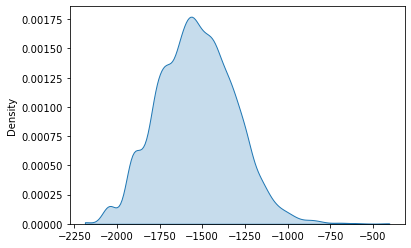

In [62]:
sns.kdeplot(energy_pbe0, shade=True, cut=0)

## Regression and Prediction

In [63]:
# find the fitting coeffecients
kernel.fit(X_train, y_train)


# and make predictions on test data
predictions = kernel.predict(X_test)

## Error

We have now predicted the energies for the test set, let us now see how well the model worked.

MAE: 8.400127962373983 kcal/mol
MSE: 125.48005282880713 kcal/mol
RMSE: 11.201787930005064 kcal/mol


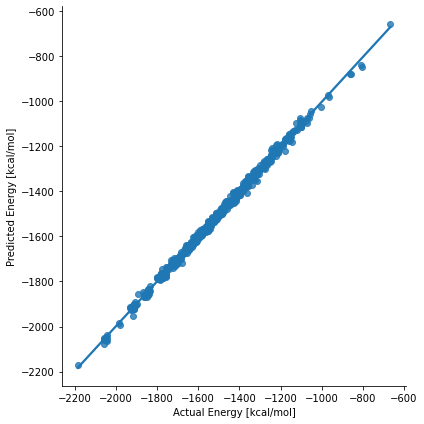

In [64]:
data=pd.DataFrame(data={'Actual Energy [kcal/mol]': y_test, 'Predicted Energy [kcal/mol]': predictions})
sns.lmplot(x="Actual Energy [kcal/mol]",y="Predicted Energy [kcal/mol]", truncate=True, data=data, height=6)

print('MAE:', metrics.mean_absolute_error(y_test, predictions), "kcal/mol")
print('MSE:', metrics.mean_squared_error(y_test, predictions), "kcal/mol")
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)), "kcal/mol")